# Compare original and smoothed topographies for COSMO and ICON

#### Load python packages

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

In [15]:
from utils import ind_from_latlon_regular
from utils import get_poi
from utils import indices_transect

In [24]:
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250
plt.rcParams['font.size'] = 7

#### Files used for analysis
- COSMO original interpolated from ASTER dataset
- COSMO filtered with operational settings
- ICON original interpolated from ASTER dataset
- ICON filtered with 1 iteration with fac_smooth_topo=64

In [6]:
f_cosmo_orig = '/store/mch/msopr/swester/vert_coord_files/cosmo_topo/topography_reg_1_nofilter.nc'
f_cosmo_filtered = '/store/mch/msopr/swester/vert_coord_files/cosmo_topo/topography_reg_1_filter.nc'
f_icon_grid = '/store/mch/msopr/swester/grids/alps_R19B08/alps_DOM01.nc'
f_icon_orig = '/store/mch/msopr/swester/vert_coord_files/surf/niter_0.nc'
f_icon_niter1_fac64 = '/store/mch/msopr/swester/vert_coord_files/surf/niter_1_fac_64.nc'

In [13]:
ds_cosmo_orig = xr.open_dataset(f_cosmo_orig)
ds_cosmo_filtered = xr.open_dataset(f_cosmo_filtered)
ds_icon_orig = xr.open_dataset(f_icon_orig)
ds_icon_niter1_fac64 = xr.open_dataset(f_icon_niter1_fac64)
ds_grid = xr.open_dataset(f_icon_grid)


#### Load latitude and longitude

In [8]:
lats_cosmo = ds_cosmo_orig.lat.values
lons_cosmo = ds_cosmo_orig.lon.values
lats_icon  = np.rad2deg(ds_icon_orig.clat.values)
lons_icon  = np.rad2deg(ds_icon_orig.clon.values)

#### Load HSURF

In [9]:
hsurf_cosmo_orig = ds_cosmo_orig.HSURF.values
hsurf_cosmo_filtered = ds_cosmo_filtered.HSURF.values
hsurf_icon_orig = ds_icon_orig.HSURF.values
hsurf_icon_niter1_fac64 = ds_icon_niter1_fac64.HSURF.values

#### Indices for selected points of interest
Load poi for ICON, add indices for COSMO

In [11]:
poi_icon = get_poi(lats_icon, lons_icon)
ind_cosmo = pd.DataFrame(columns=poi_icon.columns,index=['ind_cosmo_lat', 'ind_cosmo_lon'])
for (column, content) in ind_cosmo.items():
    ind_lat, ind_lon = ind_from_latlon_regular(lats_cosmo, lons_cosmo,
                                               poi_icon[column].lat, poi_icon[column].lon,
                                               verbose=False)
    content['ind_cosmo_lat'] = ind_lat
    content['ind_cosmo_lon'] = ind_lon
poi = pd.concat([poi_icon, ind_cosmo])
poi

,mtblanc,zrh,pay,visp,ulr,sav,duf,cic,ste
long_name,Mt Blanc,Zürich,Payerne,Visp,Ulrichen,Savona,Dufourspitze,Cicognola,Steffisburg
ind,271322,323689,278763,306987,299455,142601,310059,293786,304032
h_real,4808.0,422.0,491.0,646.0,1345.0,0.0,4634.0,197.0,586.0
lat,45.83267,47.46218,46.81291,46.29861,46.50568,44.27691,45.93692,45.7235,46.77884
lon,6.86437,8.54458,6.94418,7.88004,8.3061,8.54675,7.86675,8.61444,7.63525
ind_cosmo_lat,322,480,420,365,385,161,329,306,414
ind_cosmo_lon,464,587,475,537,567,575,534,586,522


## COSMO

Text(0.5, 0.98, 'COSMO topography')

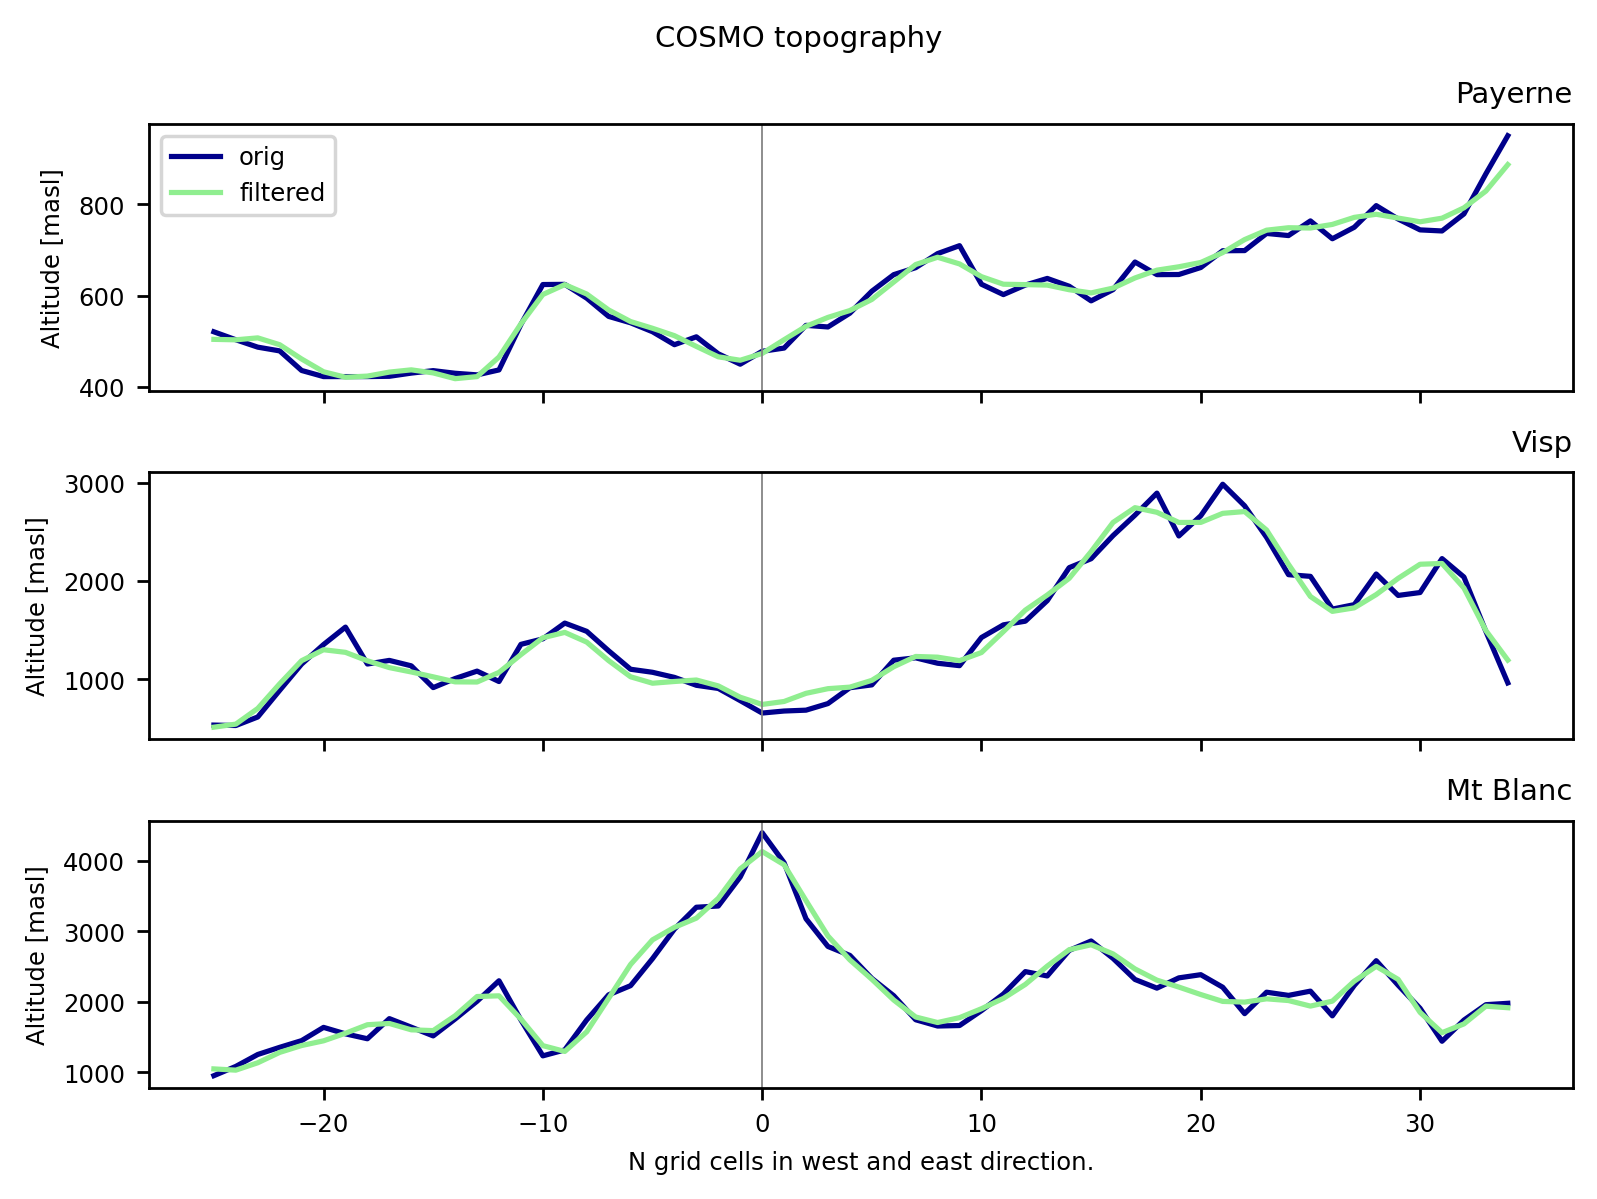

In [25]:
fig, [ax_pay, ax_visp, ax_mtblanc] = plt.subplots(nrows=3, ncols=1, sharex=True, tight_layout=True)
n_west = 25
n_east = 35
n_vector = np.arange(-n_west,n_east)

for (ax, p) in [(ax_pay, poi['pay']), (ax_visp, poi['visp']), (ax_mtblanc, poi['mtblanc'])]:
    ax.plot(n_vector,
            hsurf_cosmo_orig[p.ind_cosmo_lat, (p.ind_cosmo_lon-n_west):(p.ind_cosmo_lon+n_east)],
            color='darkblue',
            label='orig')
    ax.plot(n_vector,
            hsurf_cosmo_filtered[p.ind_cosmo_lat, (p.ind_cosmo_lon-n_west):(p.ind_cosmo_lon+n_east)],
            color='lightgreen',
            label='filtered')
    ax.axvline(0, linewidth=0.5, color="grey")
    ax.set_ylabel('Altitude [masl]')
    ax.set_title(p.long_name, loc='right')

ax_pay.legend()
ax_mtblanc.set_xlabel('N grid cells in west and east direction.')
fig.suptitle('COSMO topography')

## ICON

Text(0.5, 0.98, 'ICON topography')

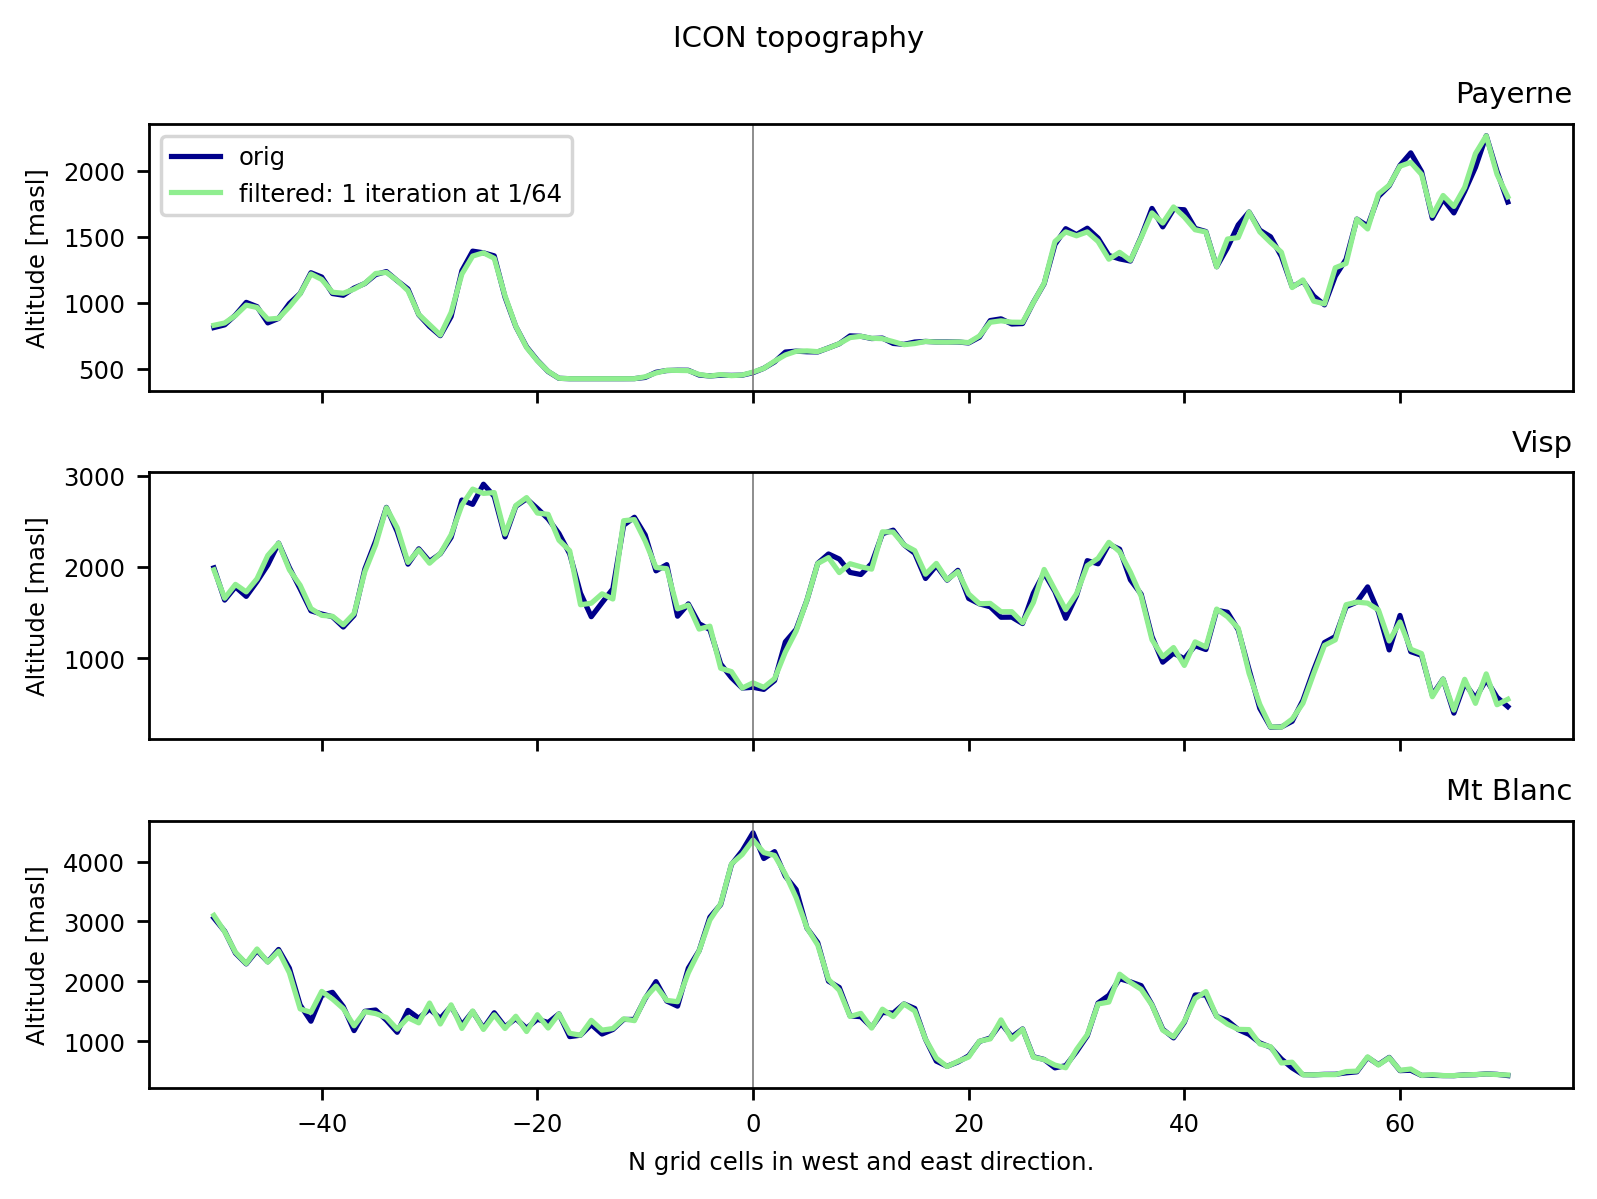

In [26]:
neighbors = ds_grid.neighbor_cell_index.values
fig, [ax_pay, ax_visp, ax_mtblanc] = plt.subplots(nrows=3, ncols=1, sharex=True, tight_layout=True)

for (ax, p) in [(ax_pay, poi['pay']), (ax_visp, poi['visp']), (ax_mtblanc, poi['mtblanc'])]:
    ind_line, ind_wrt_origin = indices_transect(p.ind, neighbors)
    transect_surf_orig = hsurf_icon_orig[ind_line]
    transect_surf_niter1_fac64 = hsurf_icon_niter1_fac64[ind_line]
    ax.plot(ind_wrt_origin, transect_surf_orig, color='darkblue', label='orig')
    ax.plot(ind_wrt_origin, transect_surf_niter1_fac64, color='lightgreen', label='filtered: 1 iteration at 1/64')
    ax.axvline(0, linewidth=0.5, color="grey")
    ax.set_ylabel('Altitude [masl]')
    ax.set_title(p.long_name, loc='right')

ax_pay.legend()
ax_mtblanc.set_xlabel('N grid cells in west and east direction.')
fig.suptitle('ICON topography')
    
    